# Introduction to the experiment 1

In this experiment, we use the setup below:

<img src="img/test1.png" />

The structure of this notebook has 3 parts:
1. Baseline case
2. Defense with Direct Power Injection
3. Defense with Adaptive Voltage Bias

# Baseline

In [12]:
import pycigar
import pandas as pd
import numpy as np
from pycigar.utils.input_parser import input_parser
from pycigar.utils.registry import register_devcon

from pycigar.controllers.custom_hack_controller import CustomHackController
from pycigar.controllers.fixed_controller import FixedController
from pycigar.controllers.MRAC_adaptive_controller import MRAC_adaptive_controller
from pycigar.devices.direct_power_injection_device import DirectPowerInjectionDevice
from pycigar.devices.pv_inverter_device import PVDevice

In [3]:
register_devcon('Attacker', CustomHackController)
register_devcon('Defender', FixedController)
register_devcon('custom_pv_device', DirectPowerInjectionDevice)

'custom_pv_device'

In [4]:
file_misc_inputs_path = pycigar.DATA_DIR + '/ieee37busdata/misc_inputs.csv'
misc_inputs = pd.read_csv(pycigar.DATA_DIR + '/ieee37busdata/misc_inputs.csv', index_col=0, header=None, names=['parameter', 'value'])
misc_inputs.value['hack start']=250
misc_inputs.value['hack end']=2000
misc_inputs.value['hack update']=4000
misc_inputs.value['measurement filter time constant mean']=1
misc_inputs.value['measurement filter time constant avg v']=10
misc_inputs.value['gamma']=50   #control=1
misc_inputs.value['k']=0
misc_inputs.value['epsilon']=1e-7
misc_inputs.to_csv(pycigar.DATA_DIR + '/ieee37busdata/misc_inputs.csv', header=None)

# We set hack percentage at all loads to 0.
hack = 0.0

# We set these loads to be fully controlled by the attackers.
nodes_hack = ['s722b', 's712c', 's727c', 's738a', 's736b', 's730c', 's729a', 's725b', 's728']

In [5]:
# initialize the simulation parameters
misc_inputs = pycigar.DATA_DIR + '/ieee37busdata/misc_inputs.csv'
dss = pycigar.DATA_DIR + '/ieee37busdata/ieee37.dss'
load_solar = pycigar.DATA_DIR + '/ieee37busdata/load_solar_data.csv'
breakpoints = pycigar.DATA_DIR + '/ieee37busdata/breakpoints.csv'


sim_params = input_parser(misc_inputs, dss, load_solar, breakpoints, benchmark=True, percentage_hack=hack, vectorized_mode=False)
start = 100
sim_params['scenario_config']['start_end_time'] = [start, start + 1500]  # fix the exp start and end time

# set the percentage hack to 100% for loads in nodes_hack
for node in sim_params['scenario_config']['nodes']:
    if node['name'] in nodes_hack:
        node['devices'][0]['hack'] = [250.0, 1.0, 2000.0]

sim_params['env_config']['sims_per_step'] = 1 # on 1 step call, it is equal to 1 simulation step.
del sim_params['attack_randomization'] # turn off the attack randomization

from pycigar.envs.norl_env import NoRLEnv
env = NoRLEnv(sim_params=sim_params) # init env with the sim_params above

env.reset()
done = False
while not done:
    done = env.step() # every step call will return done, the status whether the exp is finished or not

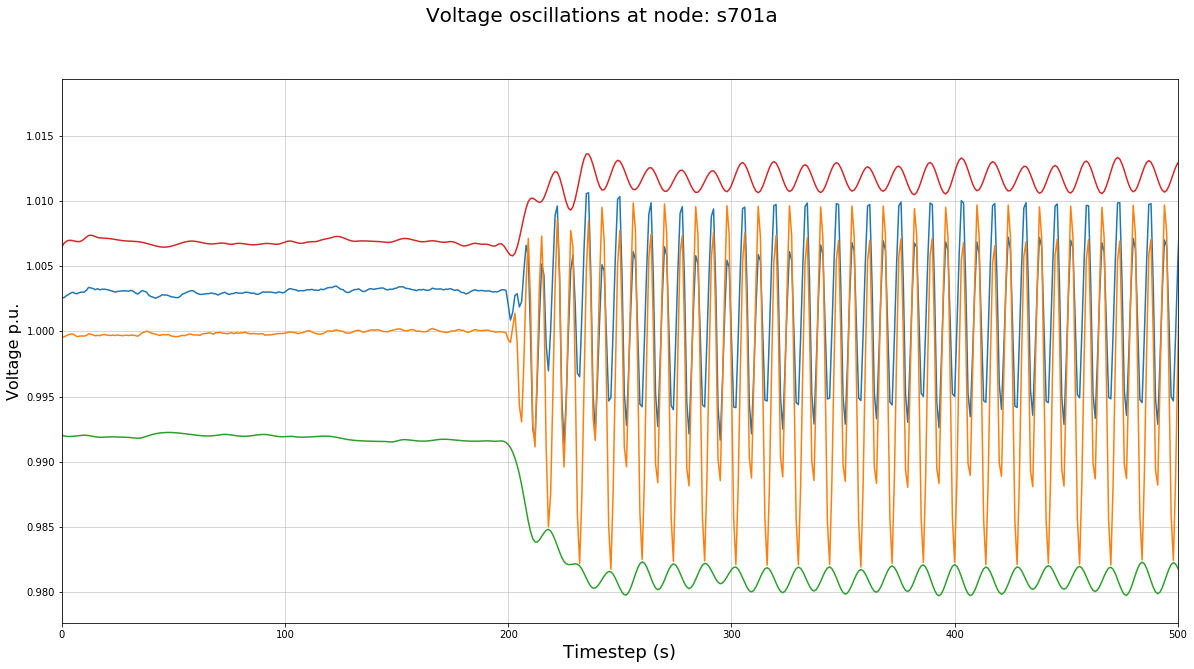

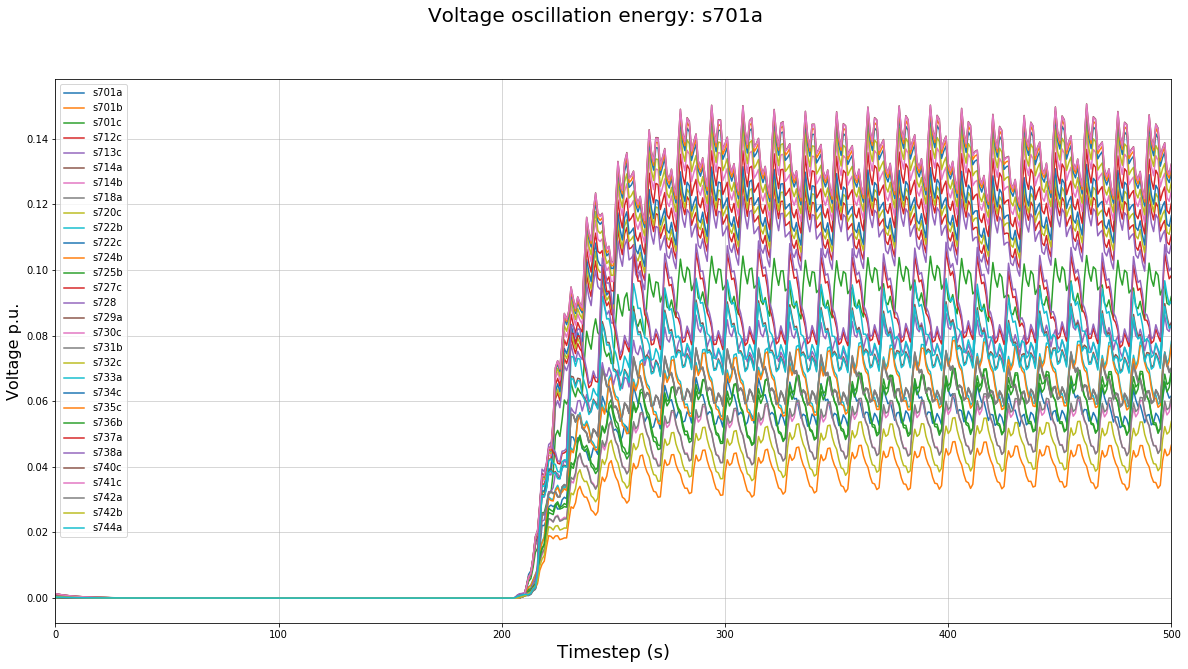

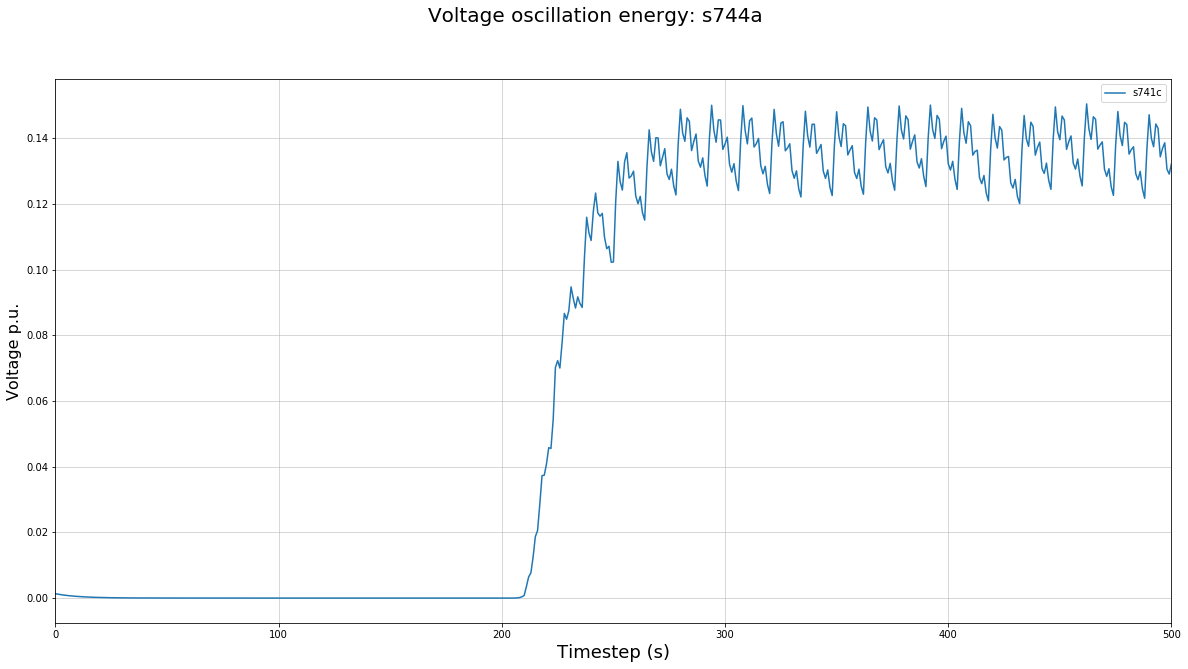

In [14]:
from scipy.interpolate import interp1d
def envelope(signal):
    s = np.array(signal) #This is your noisy vector of values.

    q_u = np.zeros(s.shape)
    q_l = np.zeros(s.shape)

    #Prepend the first value of (s) to the interpolating values. This forces the model to use the same starting point for both the upper and lower envelope models.

    u_x = [0,]
    u_y = [s[0],]

    l_x = [0,]
    l_y = [s[0],]

    #Detect peaks and troughs and mark their location in u_x,u_y,l_x,l_y respectively.

    for k in range(1,len(s)-1):
        if (np.sign(s[k]-s[k-1])==1) and (np.sign(s[k]-s[k+1])==1):
            u_x.append(k)
            u_y.append(s[k])

        if (np.sign(s[k]-s[k-1])==-1) and ((np.sign(s[k]-s[k+1]))==-1):
            l_x.append(k)
            l_y.append(s[k])

    #Append the last value of (s) to the interpolating values. This forces the model to use the same ending point for both the upper and lower envelope models.

    u_x.append(len(s)-1)
    u_y.append(s[-1])

    l_x.append(len(s)-1)
    l_y.append(s[-1])

    #Fit suitable models to the data. Here I am using cubic splines, similarly to the MATLAB example given in the question.

    u_p = interp1d(u_x,u_y, kind = 'cubic',bounds_error = False, fill_value=0.0)
    l_p = interp1d(l_x,l_y,kind = 'cubic',bounds_error = False, fill_value=0.0)

    #Evaluate each model over the domain of (s)
    for k in range(0,len(s)):
        q_u[k] = u_p(k)
        q_l[k] = l_p(k)

    #Plot everything
    return q_u, q_l

from pycigar.utils.logging import logger
Logger = logger()

import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(20, 10))

nodes = [node for node in Logger.log_dict.keys() if node[0] == 's']
inverters = [inverter for inverter in Logger.log_dict.keys() if 'inverter' in inverter]
all_voltages = []
all_y = []
for node_id in nodes:
    all_voltages.append(Logger.log_dict[node_id]['voltage'])
for inverter_id in inverters:
    all_y.append(Logger.log_dict[inverter_id]['y'])
all_voltages = np.array(all_voltages)

#all_voltages_mean = np.mean(all_voltages[0:100], axis=1)
#all_voltages -= all_voltages_mean.reshape(30,1)
min_voltage = np.min(all_voltages, axis=0)
max_voltage = np.max(all_voltages, axis=0)

_, min_bound = envelope(min_voltage)
max_bound, _ = envelope(max_voltage)

ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 500])

node_id = 's701a'
f.suptitle('Voltage oscillations at node: {}'.format(node_id), fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('Voltage p.u.', fontsize=16)
ax.plot(Logger.log_dict[node_id]['voltage'])
ax.plot(Logger.log_dict['s741c']['voltage'])
#ax.plot(all_voltages[0])
ax.plot(min_bound)
ax.plot(max_bound)
plt.show()

f, ax = plt.subplots(figsize=(20, 10))

ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 500])
min_y = np.min(all_y, axis=0)
max_y = np.max(all_y, axis=0)
mean_y = np.mean(all_y, axis=0)
std_y = np.std(all_y, axis=0)
f.suptitle('Voltage oscillation energy: {}'.format(node_id), fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('Voltage p.u.', fontsize=16)
#ax.plot(max_y)
#ax.plot(min_y)
#ax.plot(mean_y)
#ax.plot(mean_y + std_y)
#ax.plot(mean_y - std_y)
for node_id in nodes:
    plt.plot(Logger.log_dict['inverter_' + node_id]['y'], label=node_id)
plt.legend()
plt.show()

f, ax = plt.subplots(figsize=(20, 10))
ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 500])
min_y = np.min(all_y, axis=0)
max_y = np.max(all_y, axis=0)
mean_y = np.mean(all_y, axis=0)
std_y = np.std(all_y, axis=0)
percentile_25 = np.percentile(all_y, 25, axis=0)
percentile_75 = np.percentile(all_y, 75, axis=0)
f.suptitle('Voltage oscillation energy: {}'.format(node_id), fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('Voltage p.u.', fontsize=16)
#ax.plot(max_y)
#ax.plot(min_y)
#ax.plot(mean_y)
#ax.plot(mean_y + std_y)
#ax.plot(mean_y - std_y)
node_id = 's741c'
plt.plot(Logger.log_dict['inverter_' + node_id]['y'], label=node_id)
plt.legend()
plt.show()


# Defense with Direct Power Injection
ATTENTION: RESTART THE KERNEL BEFORE RUNNING THE BLOCKS FOR THIS EXPERIMENTS


In [1]:
import pycigar
import pandas as pd
import numpy as np
from pycigar.utils.input_parser import input_parser
from pycigar.utils.registry import register_devcon

from pycigar.controllers.custom_hack_controller import CustomHackController
from pycigar.controllers.fixed_controller import FixedController
from pycigar.controllers.MRAC_adaptive_controller import MRAC_adaptive_controller
from pycigar.devices.direct_power_injection_device import DirectPowerInjectionDevice
from pycigar.devices.pv_inverter_device import PVDevice

In [2]:
register_devcon('Attacker', CustomHackController)
register_devcon('Defender', MRAC_adaptive_controller)
register_devcon('custom_pv_device', DirectPowerInjectionDevice)

'custom_pv_device'

In [3]:
file_misc_inputs_path = pycigar.DATA_DIR + '/ieee37busdata/misc_inputs.csv'
misc_inputs = pd.read_csv(pycigar.DATA_DIR + '/ieee37busdata/misc_inputs.csv', index_col=0, header=None, names=['parameter', 'value'])
misc_inputs.value['hack start']=250
misc_inputs.value['hack end']=2000
misc_inputs.value['hack update']=4000
misc_inputs.value['measurement filter time constant mean']=1
misc_inputs.value['measurement filter time constant avg v']=10
misc_inputs.value['gamma']=50   #control=1
misc_inputs.value['k']=0
misc_inputs.value['epsilon']=1e-7
misc_inputs.to_csv(pycigar.DATA_DIR + '/ieee37busdata/misc_inputs.csv', header=None)

# We set hack percentage at all loads to 0.
hack = 0.0

# We set these loads to be fully controlled by the attackers.
nodes_hack = ['s722b', 's712c', 's727c', 's738a', 's736b', 's730c', 's729a', 's725b', 's728']

In [4]:
# initialize the simulation parameters
misc_inputs = pycigar.DATA_DIR + '/ieee37busdata/misc_inputs.csv'
dss = pycigar.DATA_DIR + '/ieee37busdata/ieee37.dss'
load_solar = pycigar.DATA_DIR + '/ieee37busdata/load_solar_data.csv'
breakpoints = pycigar.DATA_DIR + '/ieee37busdata/breakpoints.csv'


sim_params = input_parser(misc_inputs, dss, load_solar, breakpoints, benchmark=True, percentage_hack=hack, vectorized_mode=False)
start = 100
sim_params['scenario_config']['start_end_time'] = [start, start + 1500]  # fix the exp start and end time

# set the percentage hack to 100% for loads in nodes_hack
for node in sim_params['scenario_config']['nodes']:
    if node['name'] in nodes_hack:
        node['devices'][0]['hack'] = [250.0, 1.0, 2000.0]

sim_params['env_config']['sims_per_step'] = 1 # on 1 step call, it is equal to 1 simulation step.
del sim_params['attack_randomization'] # turn off the attack randomization

from pycigar.envs.norl_env import NoRLEnv
env = NoRLEnv(sim_params=sim_params) # init env with the sim_params above

env.reset()
done = False
while not done:
    done = env.step() # every step call will return done, the status whether the exp is finished or not

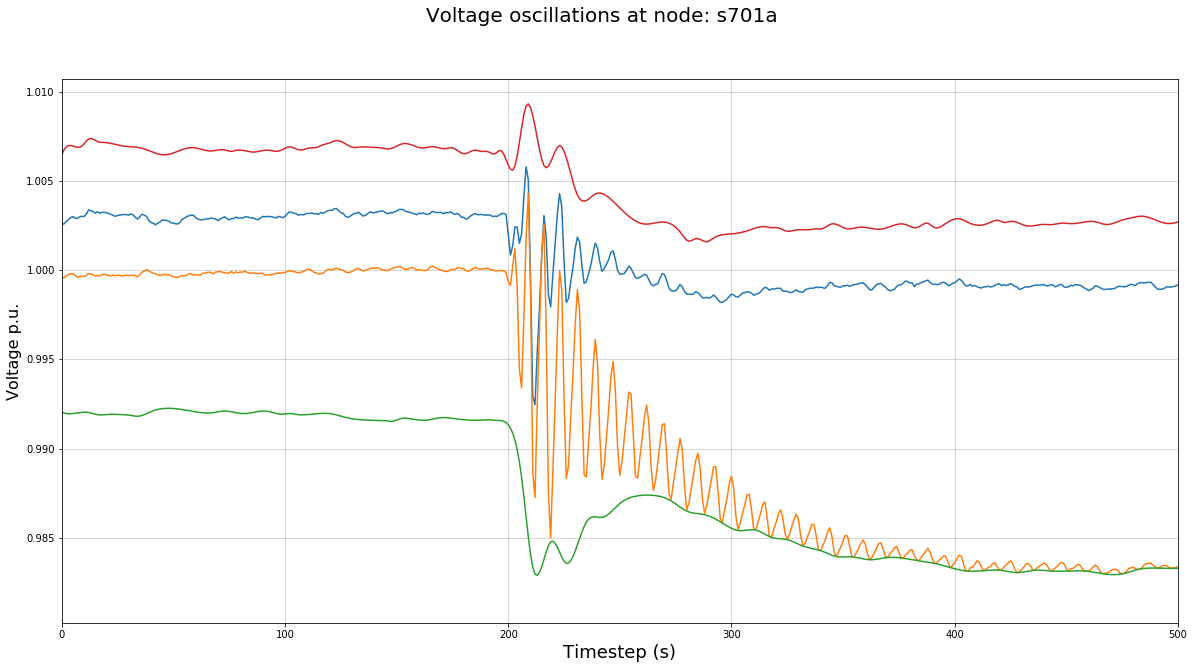

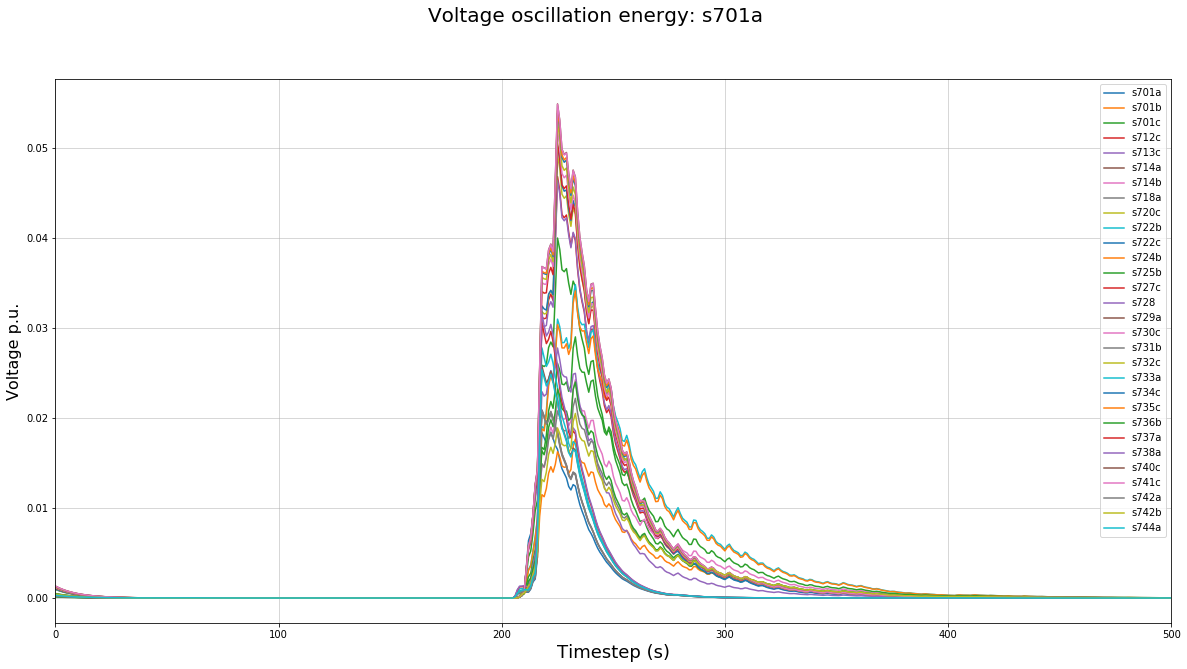

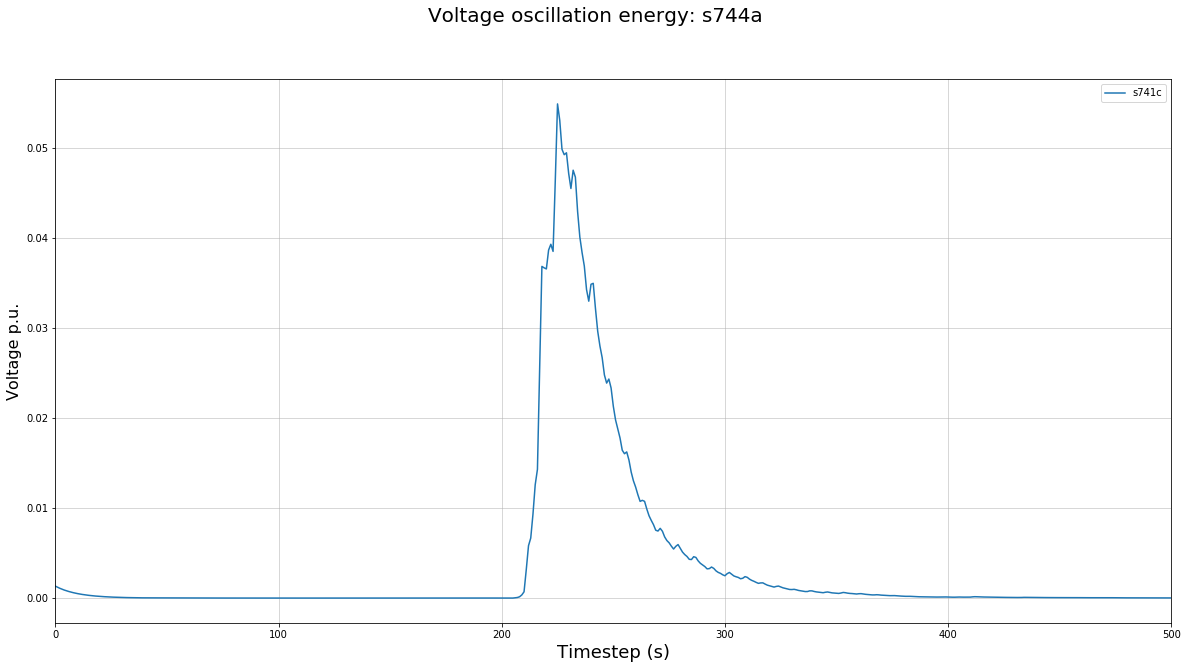

In [5]:
from scipy.interpolate import interp1d
def envelope(signal):
    s = np.array(signal) #This is your noisy vector of values.

    q_u = np.zeros(s.shape)
    q_l = np.zeros(s.shape)

    #Prepend the first value of (s) to the interpolating values. This forces the model to use the same starting point for both the upper and lower envelope models.

    u_x = [0,]
    u_y = [s[0],]

    l_x = [0,]
    l_y = [s[0],]

    #Detect peaks and troughs and mark their location in u_x,u_y,l_x,l_y respectively.

    for k in range(1,len(s)-1):
        if (np.sign(s[k]-s[k-1])==1) and (np.sign(s[k]-s[k+1])==1):
            u_x.append(k)
            u_y.append(s[k])

        if (np.sign(s[k]-s[k-1])==-1) and ((np.sign(s[k]-s[k+1]))==-1):
            l_x.append(k)
            l_y.append(s[k])

    #Append the last value of (s) to the interpolating values. This forces the model to use the same ending point for both the upper and lower envelope models.

    u_x.append(len(s)-1)
    u_y.append(s[-1])

    l_x.append(len(s)-1)
    l_y.append(s[-1])

    #Fit suitable models to the data. Here I am using cubic splines, similarly to the MATLAB example given in the question.

    u_p = interp1d(u_x,u_y, kind = 'cubic',bounds_error = False, fill_value=0.0)
    l_p = interp1d(l_x,l_y,kind = 'cubic',bounds_error = False, fill_value=0.0)

    #Evaluate each model over the domain of (s)
    for k in range(0,len(s)):
        q_u[k] = u_p(k)
        q_l[k] = l_p(k)

    #Plot everything
    return q_u, q_l

from pycigar.utils.logging import logger
Logger = logger()

import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(20, 10))

nodes = [node for node in Logger.log_dict.keys() if node[0] == 's']
inverters = [inverter for inverter in Logger.log_dict.keys() if 'inverter' in inverter]
all_voltages = []
all_y = []
for node_id in nodes:
    all_voltages.append(Logger.log_dict[node_id]['voltage'])
for inverter_id in inverters:
    all_y.append(Logger.log_dict[inverter_id]['y'])
all_voltages = np.array(all_voltages)

#all_voltages_mean = np.mean(all_voltages[0:100], axis=1)
#all_voltages -= all_voltages_mean.reshape(30,1)
min_voltage = np.min(all_voltages, axis=0)
max_voltage = np.max(all_voltages, axis=0)

_, min_bound = envelope(min_voltage)
max_bound, _ = envelope(max_voltage)

ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 500])

node_id = 's701a'
f.suptitle('Voltage oscillations at node: {}'.format(node_id), fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('Voltage p.u.', fontsize=16)
ax.plot(Logger.log_dict[node_id]['voltage'])
ax.plot(Logger.log_dict['s741c']['voltage'])
#ax.plot(all_voltages[0])
ax.plot(min_bound)
ax.plot(max_bound)
plt.show()

f, ax = plt.subplots(figsize=(20, 10))

ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 500])
min_y = np.min(all_y, axis=0)
max_y = np.max(all_y, axis=0)
mean_y = np.mean(all_y, axis=0)
std_y = np.std(all_y, axis=0)
f.suptitle('Voltage oscillation energy: {}'.format(node_id), fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('Voltage p.u.', fontsize=16)
#ax.plot(max_y)
#ax.plot(min_y)
#ax.plot(mean_y)
#ax.plot(mean_y + std_y)
#ax.plot(mean_y - std_y)
for node_id in nodes:
    plt.plot(Logger.log_dict['inverter_' + node_id]['y'], label=node_id)
plt.legend()
plt.show()

f, ax = plt.subplots(figsize=(20, 10))
ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 500])
min_y = np.min(all_y, axis=0)
max_y = np.max(all_y, axis=0)
mean_y = np.mean(all_y, axis=0)
std_y = np.std(all_y, axis=0)
percentile_25 = np.percentile(all_y, 25, axis=0)
percentile_75 = np.percentile(all_y, 75, axis=0)
f.suptitle('Voltage oscillation energy: {}'.format(node_id), fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('Voltage p.u.', fontsize=16)
#ax.plot(max_y)
#ax.plot(min_y)
#ax.plot(mean_y)
#ax.plot(mean_y + std_y)
#ax.plot(mean_y - std_y)
node_id = 's741c'
plt.plot(Logger.log_dict['inverter_' + node_id]['y'], label=node_id)
plt.legend()
plt.show()


# Defense with Adaptive Voltage Bias
ATTENTION: RESTART THE KERNEL BEFORE RUNNING THE BLOCKS FOR THIS EXPERIMENTS


In [1]:
import pycigar
import pandas as pd
import numpy as np
from pycigar.utils.input_parser import input_parser
from pycigar.utils.registry import register_devcon

from pycigar.controllers.custom_hack_controller import CustomHackController
from pycigar.controllers.fixed_controller import FixedController
from pycigar.controllers.MRAC_adaptive_controller import MRAC_adaptive_controller
from pycigar.devices.direct_power_injection_device import DirectPowerInjectionDevice
from pycigar.devices.pv_inverter_device import PVDevice

In [2]:
register_devcon('Attacker', CustomHackController)
register_devcon('Defender', MRAC_adaptive_controller)
register_devcon('custom_pv_device', PVDevice)

'custom_pv_device'

In [9]:
file_misc_inputs_path = pycigar.DATA_DIR + '/ieee37busdata/misc_inputs.csv'
misc_inputs = pd.read_csv(pycigar.DATA_DIR + '/ieee37busdata/misc_inputs.csv', index_col=0, header=None, names=['parameter', 'value'])
misc_inputs.value['hack start']=250
misc_inputs.value['hack end']=2000
misc_inputs.value['hack update']=4000
misc_inputs.value['measurement filter time constant mean']=1
misc_inputs.value['measurement filter time constant avg v']=10
misc_inputs.value['gamma']=0.5   #control=1
misc_inputs.value['k']=0
misc_inputs.value['epsilon']=1e-7
misc_inputs.to_csv(pycigar.DATA_DIR + '/ieee37busdata/misc_inputs.csv', header=None)

# We set hack percentage at all loads to 0.
hack = 0.0

# We set these loads to be fully controlled by the attackers.
nodes_hack = ['s722b', 's712c', 's727c', 's738a', 's736b', 's730c', 's729a', 's725b', 's728']

In [10]:
# initialize the simulation parameters
misc_inputs = pycigar.DATA_DIR + '/ieee37busdata/misc_inputs.csv'
dss = pycigar.DATA_DIR + '/ieee37busdata/ieee37.dss'
load_solar = pycigar.DATA_DIR + '/ieee37busdata/load_solar_data.csv'
breakpoints = pycigar.DATA_DIR + '/ieee37busdata/breakpoints.csv'


sim_params = input_parser(misc_inputs, dss, load_solar, breakpoints, benchmark=True, percentage_hack=hack, vectorized_mode=False)
start = 100
sim_params['scenario_config']['start_end_time'] = [start, start + 1500]  # fix the exp start and end time

# set the percentage hack to 100% for loads in nodes_hack
for node in sim_params['scenario_config']['nodes']:
    if node['name'] in nodes_hack:
        node['devices'][0]['hack'] = [250.0, 1.0, 2000.0]

sim_params['env_config']['sims_per_step'] = 1 # on 1 step call, it is equal to 1 simulation step.
del sim_params['attack_randomization'] # turn off the attack randomization

from pycigar.envs.norl_env import NoRLEnv
env = NoRLEnv(sim_params=sim_params) # init env with the sim_params above

env.reset()
done = False
while not done:
    done = env.step() # every step call will return done, the status whether the exp is finished or not

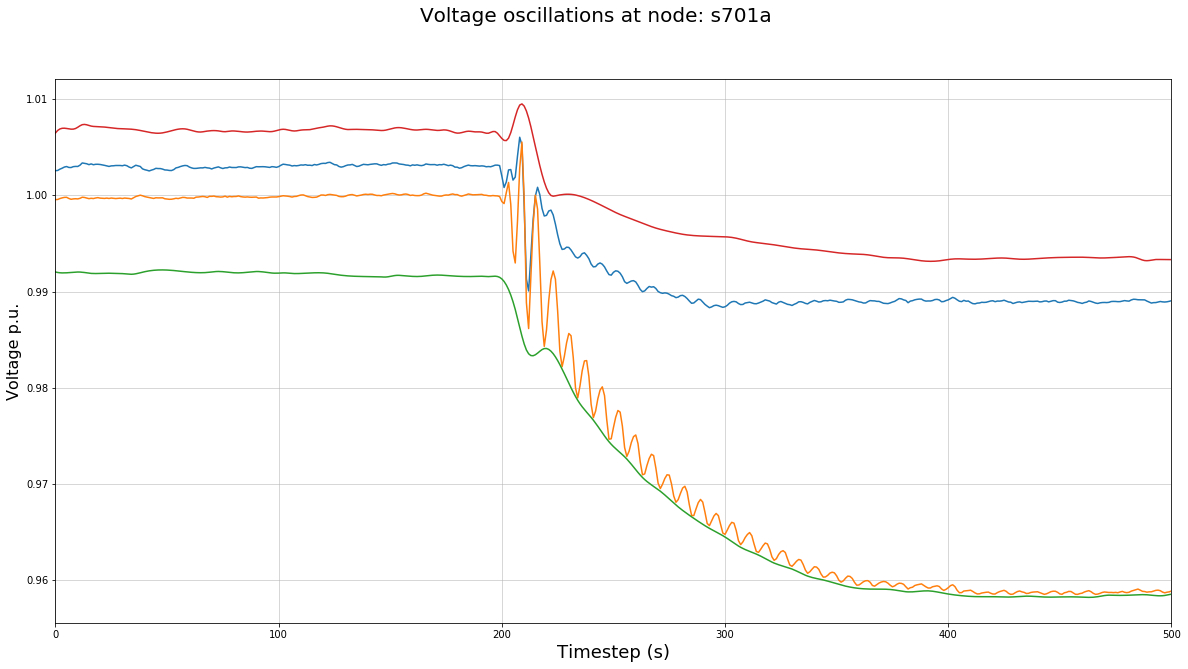

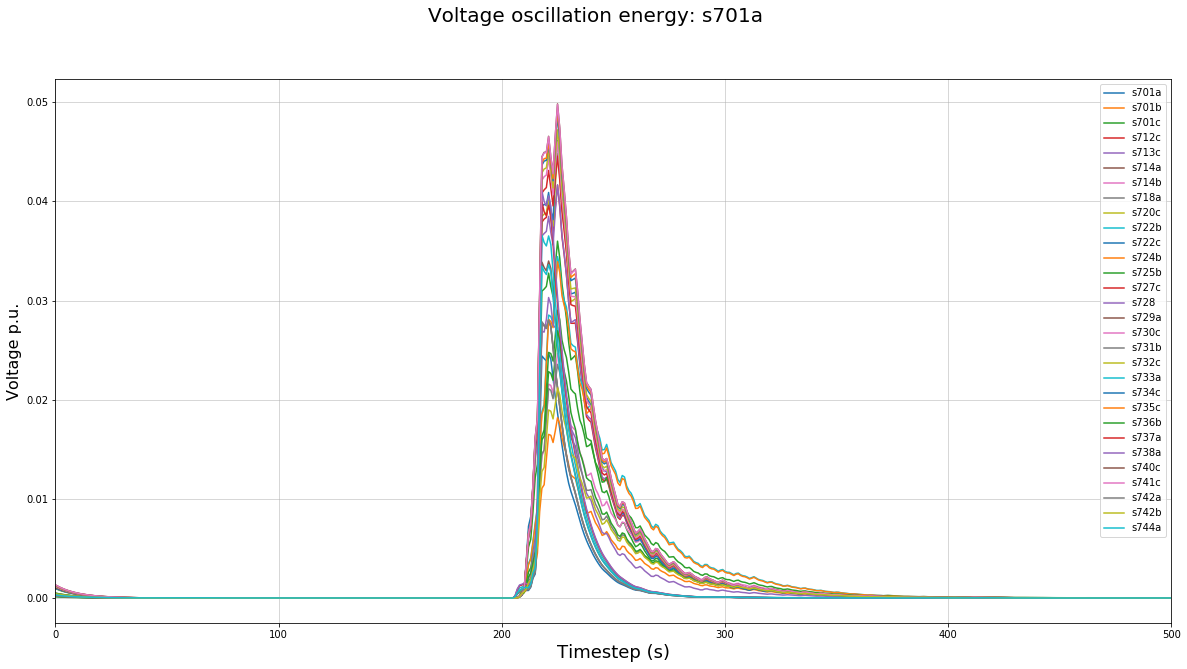

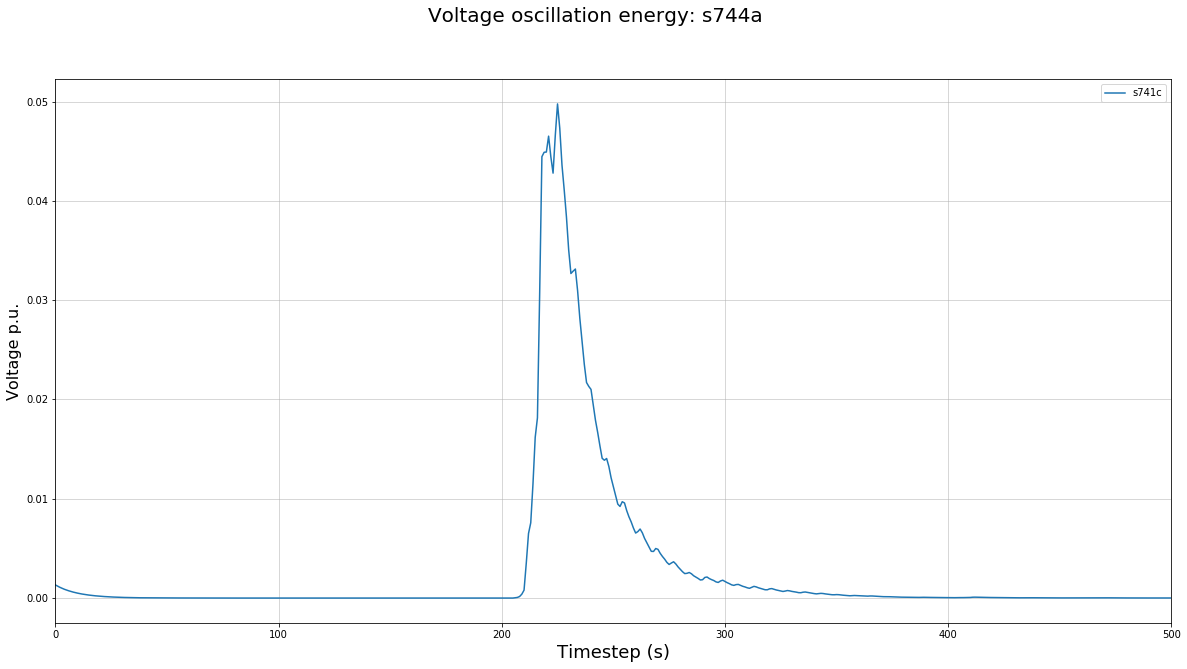

In [11]:
from scipy.interpolate import interp1d
def envelope(signal):
    s = np.array(signal) #This is your noisy vector of values.

    q_u = np.zeros(s.shape)
    q_l = np.zeros(s.shape)

    #Prepend the first value of (s) to the interpolating values. This forces the model to use the same starting point for both the upper and lower envelope models.

    u_x = [0,]
    u_y = [s[0],]

    l_x = [0,]
    l_y = [s[0],]

    #Detect peaks and troughs and mark their location in u_x,u_y,l_x,l_y respectively.

    for k in range(1,len(s)-1):
        if (np.sign(s[k]-s[k-1])==1) and (np.sign(s[k]-s[k+1])==1):
            u_x.append(k)
            u_y.append(s[k])

        if (np.sign(s[k]-s[k-1])==-1) and ((np.sign(s[k]-s[k+1]))==-1):
            l_x.append(k)
            l_y.append(s[k])

    #Append the last value of (s) to the interpolating values. This forces the model to use the same ending point for both the upper and lower envelope models.

    u_x.append(len(s)-1)
    u_y.append(s[-1])

    l_x.append(len(s)-1)
    l_y.append(s[-1])

    #Fit suitable models to the data. Here I am using cubic splines, similarly to the MATLAB example given in the question.

    u_p = interp1d(u_x,u_y, kind = 'cubic',bounds_error = False, fill_value=0.0)
    l_p = interp1d(l_x,l_y,kind = 'cubic',bounds_error = False, fill_value=0.0)

    #Evaluate each model over the domain of (s)
    for k in range(0,len(s)):
        q_u[k] = u_p(k)
        q_l[k] = l_p(k)

    #Plot everything
    return q_u, q_l

from pycigar.utils.logging import logger
Logger = logger()

import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(20, 10))

nodes = [node for node in Logger.log_dict.keys() if node[0] == 's']
inverters = [inverter for inverter in Logger.log_dict.keys() if 'inverter' in inverter]
all_voltages = []
all_y = []
for node_id in nodes:
    all_voltages.append(Logger.log_dict[node_id]['voltage'])
for inverter_id in inverters:
    all_y.append(Logger.log_dict[inverter_id]['y'])
all_voltages = np.array(all_voltages)

#all_voltages_mean = np.mean(all_voltages[0:100], axis=1)
#all_voltages -= all_voltages_mean.reshape(30,1)
min_voltage = np.min(all_voltages, axis=0)
max_voltage = np.max(all_voltages, axis=0)

_, min_bound = envelope(min_voltage)
max_bound, _ = envelope(max_voltage)

ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 500])

node_id = 's701a'
f.suptitle('Voltage oscillations at node: {}'.format(node_id), fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('Voltage p.u.', fontsize=16)
ax.plot(Logger.log_dict[node_id]['voltage'])
ax.plot(Logger.log_dict['s741c']['voltage'])
#ax.plot(all_voltages[0])
ax.plot(min_bound)
ax.plot(max_bound)
plt.show()

f, ax = plt.subplots(figsize=(20, 10))

ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 500])
min_y = np.min(all_y, axis=0)
max_y = np.max(all_y, axis=0)
mean_y = np.mean(all_y, axis=0)
std_y = np.std(all_y, axis=0)
f.suptitle('Voltage oscillation energy: {}'.format(node_id), fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('Voltage p.u.', fontsize=16)
#ax.plot(max_y)
#ax.plot(min_y)
#ax.plot(mean_y)
#ax.plot(mean_y + std_y)
#ax.plot(mean_y - std_y)
for node_id in nodes:
    plt.plot(Logger.log_dict['inverter_' + node_id]['y'], label=node_id)
plt.legend()
plt.show()

f, ax = plt.subplots(figsize=(20, 10))
ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 500])
min_y = np.min(all_y, axis=0)
max_y = np.max(all_y, axis=0)
mean_y = np.mean(all_y, axis=0)
std_y = np.std(all_y, axis=0)
percentile_25 = np.percentile(all_y, 25, axis=0)
percentile_75 = np.percentile(all_y, 75, axis=0)
f.suptitle('Voltage oscillation energy: {}'.format(node_id), fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('Voltage p.u.', fontsize=16)
#ax.plot(max_y)
#ax.plot(min_y)
#ax.plot(mean_y)
#ax.plot(mean_y + std_y)
#ax.plot(mean_y - std_y)
node_id = 's741c'
plt.plot(Logger.log_dict['inverter_' + node_id]['y'], label=node_id)
plt.legend()
plt.show()
